# AlexNet

## Import Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [2]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.Flowers102(
    root = '../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((227,227)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

test_data = datasets.Flowers102(
    root='../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((227,227)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [4]:
training_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ../data/
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

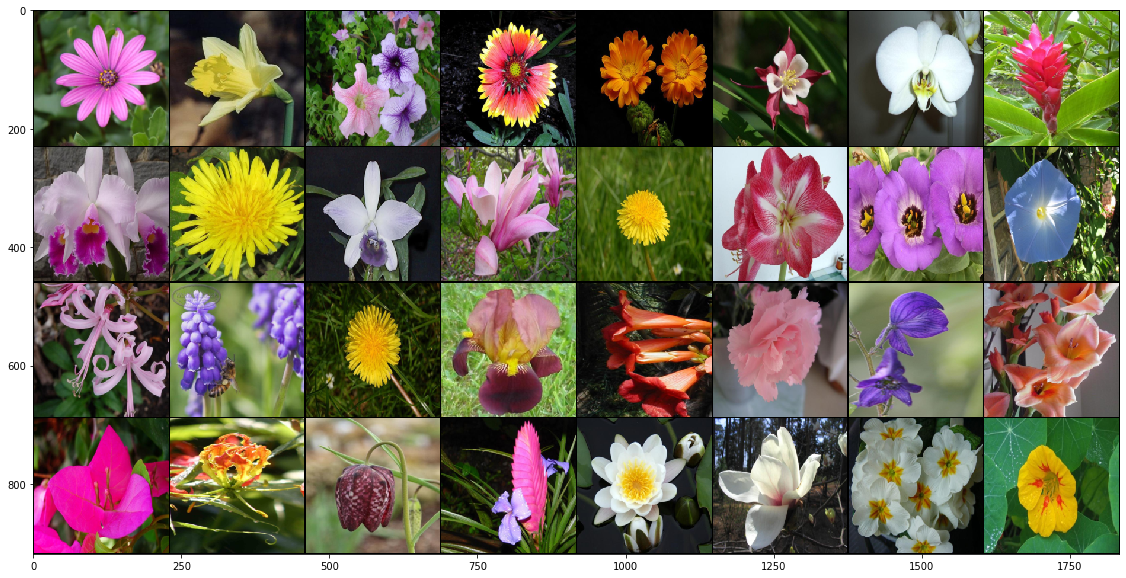

In [5]:
# sample images를 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_train = []
for batch, (X,y) in enumerate(train_dataloader):
    if batch<1:
        x_train.append(X)
    else:
        break


# tensor를 image로 변경하는 함수를 정의
def show(img):
    # tensor를 numpy array로 변경
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경
    npimg_tr = npimg.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(npimg_tr, interpolation='nearest',cmap='gray')

# images grid를 생성하고 출력
# 총 40개 이미지, 행당 8개 이미지를 출력
x_grid = utils.make_grid(x_train[0][:40], nrow=8, padding=2)

show(x_grid)

## Define Model

In [23]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes=257):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
model = AlexNet(num_classes=102)
summary(model,(3,227,227),batch_size=32)
model.to(mps_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 96, 55, 55]          34,944
              ReLU-2           [32, 96, 55, 55]               0
         MaxPool2d-3           [32, 96, 27, 27]               0
            Conv2d-4          [32, 256, 27, 27]         614,656
              ReLU-5          [32, 256, 27, 27]               0
         MaxPool2d-6          [32, 256, 13, 13]               0
            Conv2d-7          [32, 384, 13, 13]         885,120
              ReLU-8          [32, 384, 13, 13]               0
            Conv2d-9          [32, 384, 13, 13]       1,327,488
             ReLU-10          [32, 384, 13, 13]               0
           Conv2d-11          [32, 256, 13, 13]         884,992
             ReLU-12          [32, 256, 13, 13]               0
        MaxPool2d-13            [32, 256, 6, 6]               0
          Dropout-14                 [3

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): 

In [8]:
learning_rate = 0.01
epochs = 40

In [9]:
loss_fn = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay=0.0005)

In [11]:
train_acc, train_loss = [],[]
test_acc, test_loss = [],[]

In [ ]:
# # How to load model checkpoint
# model = AlexNet(num_classes=102)
# model.to(mps_device)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay=0.0005)

# checkpoint = torch.load('alex_model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epochs = checkpoint['epochs']
# train_acc = checkpoint['train_acc']
# test_acc = checkpoint['test_acc']
# train_loss = checkpoint['train_loss']
# test_loss = checkpoint['test_loss']


In [18]:
for t in range(10):
    tr_acc, tr_loss = train_loop(True,'GPU',train_dataloader,model,loss_fn,optimizer)
    te_acc, te_loss = test_loop(False, 'GPU',test_dataloader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss[-1])
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    print(f'epoch {t+1}')
    print('train loss: %.6f train acc: %.2f\ntest  loss: %.6f, test acc: %.2f' %(tr_loss[-1],100*tr_acc, te_loss, 100*te_acc))
    print('-'*10)

loss: 0.122128 [    0/ 1020]
loss: 0.021099 [  320/ 1020]
loss: 0.560665 [  640/ 1020]
loss: 0.005738 [  960/ 1020]
epoch 1
train loss: 0.005738 train acc: 100.00
test  loss: 0.091018, test acc: 98.04
----------
loss: 0.151954 [    0/ 1020]
loss: 0.056523 [  320/ 1020]
loss: 0.098288 [  640/ 1020]
loss: 0.053320 [  960/ 1020]
epoch 2
train loss: 0.053320 train acc: 96.88
test  loss: 0.123072, test acc: 97.16
----------
loss: 0.013108 [    0/ 1020]
loss: 0.089383 [  320/ 1020]
loss: 0.005807 [  640/ 1020]
loss: 0.139549 [  960/ 1020]
epoch 3
train loss: 0.139549 train acc: 96.88
test  loss: 0.050373, test acc: 98.53
----------
loss: 0.021536 [    0/ 1020]
loss: 0.007972 [  320/ 1020]
loss: 0.002842 [  640/ 1020]
loss: 0.268779 [  960/ 1020]
epoch 4
train loss: 0.268779 train acc: 96.88
test  loss: 0.026780, test acc: 99.02
----------
loss: 0.034617 [    0/ 1020]
loss: 0.044825 [  320/ 1020]
loss: 0.215325 [  640/ 1020]
loss: 0.153451 [  960/ 1020]
epoch 5
train loss: 0.153451 train acc:

In [22]:
torch.save({
    'epochs':100,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_acc' : train_acc,
    'test_acc' : test_acc,
    'train_loss' : train_loss,
    'test_loss' : test_loss,
}, 'alex_model.pt')

## Result of Flowers102 Dataset

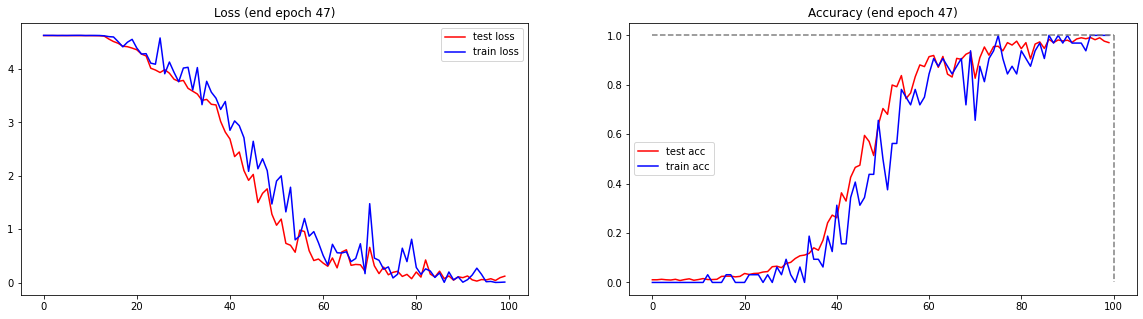

In [20]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.plot([0,100],[1,1],'--',color='gray')
ax.plot([100,100],[1,0],'--',color='gray')
ax.legend()

## Result of Caltech256 Dataset

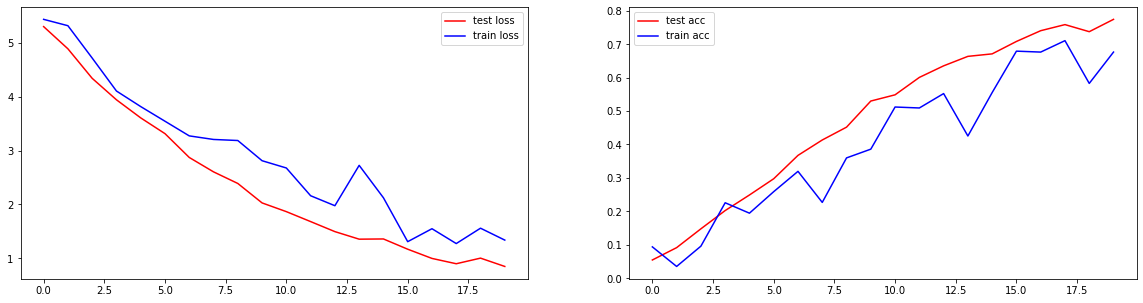

In [52]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

### 10 epochs more training

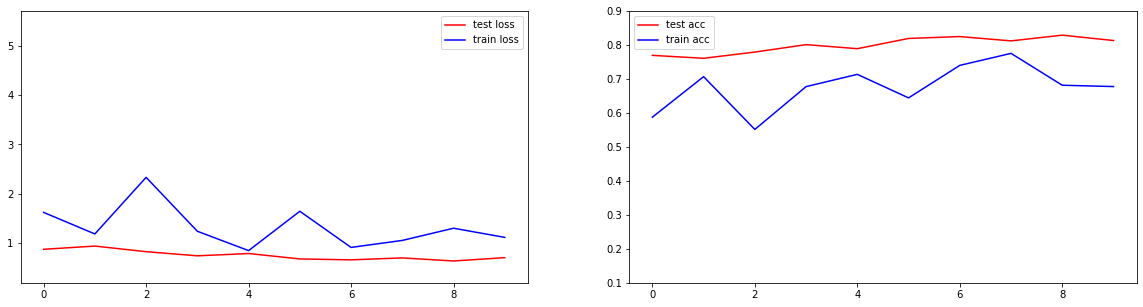

In [59]:
from matplotlib.pyplot import yticks


fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.set_ylim(0.2,5.7)
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.set_ylim(0.1,0.9)
ax.legend()